# **FINESSE Challenge - Aarish Irfan**

##Main Idea & Preliminary Design

- Devise a popularity metric through feature engineering to establish the top trending posts on Instagram in April 2020.

- Use the calculated popularity metric as the label for training a Deep Neural Network on Instagram comments.

- Model predicts whether an Instagram post would trend on the platform based on its comments. Potential usage in predicting fashion trends through NLP.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
from IPython.core.display import HTML 
!pip install emot
!pip install wget
import wget
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import tensorflow as tf

In [10]:
raw_post_metrics = pd.read_csv('/content/raw_post_metrics.csv')
raw_post_metrics.head()

,post_url,num_likes,num_comments,num_views,date_time_collected
0,https://www.instagram.com/p/B_PNBlGDTYQ/,647,15,NaN,2020-04-21 21:00:41
1,https://www.instagram.com/p/B-jWhHKjDsa/,925,105,NaN,2020-04-21 21:11:39
2,https://www.instagram.com/p/B-eNiazDOXp/,987,73,NaN,2020-04-21 21:11:42
3,https://www.instagram.com/p/B-oswDhDUB4/,960,73,NaN,2020-04-21 21:11:47
4,https://www.instagram.com/p/B-rM41AD62p/,715,67,NaN,2020-04-21 21:11:49


In [11]:
post_metrics_and_comments = pd.read_csv('/content/post_metrics_and_comments.csv')
post_metrics_and_comments.head()

,post_url,username,date_posted,img_urls,caption,max_likes,max_comments,max_views,followers,following,concatenated_comments
0,https://www.instagram.com/p/B-y2oOeDpj2/,064_steady,2020-04-10,{https://finesse-instagram-post-images.s3-us-w...,온라인개학으로 아침마다 아이들에게 모닝콜을 해줄 수 있어서 행복합니다. 하하하하😭 ...,1019,38,NaN,8423,697,@_o9.02 가입하자 연재야😘|아고 ㅠㅠㅠㅠ 힘드실텐데 아자아자 화이팅입니다 !!...
1,https://www.instagram.com/p/B_B4e5qDtOU/,064_steady,2020-04-16,{https://finesse-instagram-post-images.s3-us-w...,2014. 04. 16. 우리 모두 웃을 수 있기를... more,1039,12,NaN,8423,697,@nam_bbs 정말요?🙌|옷입는 스타일 너무너무 멋있으세요 ☺️|코디 너무 좋아요...
2,https://www.instagram.com/p/B-3-Skoj2ub/,064_steady,2020-04-12,{https://finesse-instagram-post-images.s3-us-w...,내일이 월요일이니까 웃자😁... more,764,35,NaN,8423,697,❤️|헐 선생님....멋져요....♥️|워료일 쪼아~ 최고로 쪼아~|Very sum...
3,https://www.instagram.com/p/B_UhfCuDnJU/,064_steady,2020-04-23,{https://finesse-instagram-post-images.s3-us-w...,너무 배불러요 ㅠㅠㅠ... more,779,56,NaN,8423,697,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ배불러졌다는게 너무 웃겨욬ㅋㅋㅋㅋㅋ|깔끔한 쓰앵님🤭👍🏿|😍😍😍😍❤...
4,https://www.instagram.com/p/B-6isIeD-0-/,064_steady,2020-04-13,{https://finesse-instagram-post-images.s3-us-w...,월요병 극복🥴,733,26,NaN,8423,697,극복 나이스👍🏻|@mndp404 시간은 결국 흐르니 ㅠㅠ|내일도 화요팅~!|@yeo...


In [12]:
hashtag_top_appearances = pd.read_csv('/content/hashtag_top_appearances.csv')
hashtag_top_appearances.head()

,post_url,days_in_hashtag_top_section
0,https://www.instagram.com/p/B-zJQlUI6uN/,38
1,https://www.instagram.com/p/B-cuVYrJncn/,36
2,https://www.instagram.com/p/B_CHJzXDeNF/,33
3,https://www.instagram.com/p/B-_07jGpiWT/,29
4,https://www.instagram.com/p/B-xB_snKjld/,29


## Popularity Metric with Feature Engineering

To establish top trending posts on Instagram, a popularity metric will be calcalated through feature engineering based on the following features:
- Number of Days in Hashtag Top Section
- Growth Rate
- LTF (Likes to Followers ratio)

**Number of Days in Hashtag Top Section**

Initial idea was to use the **days_in_hashtag_top_section** feature as an indicator of popularity. This was based on reasonable intuition and reliance on Instagram's algorithm to establish trending posts.

Further investigation on the **hashtag_top_appearances** dataset rendered the feature unfit to serve as the sole determinant of the popularity metric for the following reasons:
- Distribution of the feature was skewed. ~23000 posts were not featured on the top section out of ~25000 posts. 
- Likes, Comments, Views and other factors associated with social media trends were ignored.
- Using only this feature as the label in our DNN would lead to class imbalance, thus adversely affecting model training and performance.


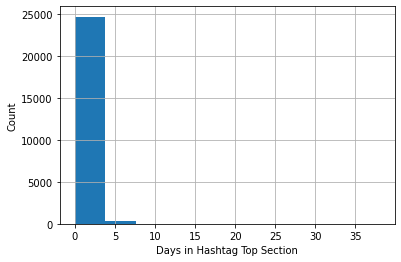

Posts not Featured on Hashtag Section: 23201
Posts Featured on Hashtag Section: 1861


In [13]:
#histogram showing skewed distribution of our hashtag feature
hashtag_top_appearances['days_in_hashtag_top_section'].hist()
plt.ylabel("Count")
plt.xlabel("Days in Hashtag Top Section")
plt.show()

print ("Posts not Featured on Hashtag Section: " + str(sum(hashtag_top_appearances['days_in_hashtag_top_section'] == 0)))
print ("Posts Featured on Hashtag Section: " + str(sum(hashtag_top_appearances['days_in_hashtag_top_section'] != 0)))

It was clear that our popularity metric needed to be an amalgam of other features associated with social media trends rather than just considering the number of days the post spent in the hashtag top section.



In [14]:
#new dataset that merged post metrics with days in hashtag section
post_popularity = post_metrics_and_comments[['post_url','img_urls','max_likes',	'max_comments',	'max_views'	,'followers',	'following']]
post_popularity_with_hashtag = post_popularity.merge(hashtag_top_appearances, on='post_url')
post_popularity_with_hashtag.head()

,post_url,img_urls,max_likes,max_comments,max_views,followers,following,days_in_hashtag_top_section
0,https://www.instagram.com/p/B-y2oOeDpj2/,{https://finesse-instagram-post-images.s3-us-w...,1019,38,NaN,8423,697,0
1,https://www.instagram.com/p/B_B4e5qDtOU/,{https://finesse-instagram-post-images.s3-us-w...,1039,12,NaN,8423,697,0
2,https://www.instagram.com/p/B-3-Skoj2ub/,{https://finesse-instagram-post-images.s3-us-w...,764,35,NaN,8423,697,0
3,https://www.instagram.com/p/B_UhfCuDnJU/,{https://finesse-instagram-post-images.s3-us-w...,779,56,NaN,8423,697,0
4,https://www.instagram.com/p/B-6isIeD-0-/,{https://finesse-instagram-post-images.s3-us-w...,733,26,NaN,8423,697,0


**Growth Rate**

Another important feature to consider while calculating a post's popularity metric is the **growth rate**. This feature boosts posts that maintained a high level of user engagement (likes, comments, views) even after several days of posting.

In [15]:
#dataset copy of metrics to calculate growth
growth_df = raw_post_metrics.copy()
growth_df['num_views'] = growth_df['num_views'].fillna(0)
growth_df.head()



,post_url,num_likes,num_comments,num_views,date_time_collected
0,https://www.instagram.com/p/B_PNBlGDTYQ/,647,15,0.0,2020-04-21 21:00:41
1,https://www.instagram.com/p/B-jWhHKjDsa/,925,105,0.0,2020-04-21 21:11:39
2,https://www.instagram.com/p/B-eNiazDOXp/,987,73,0.0,2020-04-21 21:11:42
3,https://www.instagram.com/p/B-oswDhDUB4/,960,73,0.0,2020-04-21 21:11:47
4,https://www.instagram.com/p/B-rM41AD62p/,715,67,0.0,2020-04-21 21:11:49


The growth rate was based on the percent increase of user engagements per day.

The formula used to calculate the **growth rate**:
 
 $ \frac{(100 * \frac{engagements_{final} - engagements_{initial}}{ engagements_{initial}})}{days} + 1
 $

The following code calculates the growth rate for each post.
 
**Some Problems with Data:**
- Some posts didn't have data for multiple days. Their growth rate was simply calculated as 1.
- Some instances where a post was deleted/data was corrupted and the final number of likes ended up as zero. To counter this issue, if such an instance was seen, the likes on the second last day before data corruption were considered.
- Some posts had zero engagements, leading to infinity values. Issue was rectified by adding a smoothing parameter of 1.


In [16]:
#cell takes ~2 minutes to run

#group dataframe by post
x = growth_df.groupby('post_url')

#intialize arrays with post and growth rates
post_urls = []
growth_rates = []

#loop through each post
for name,group in x:
  df = pd.DataFrame(group)

  #convert the date from a string to datatime format
  df['date_time_collected'] = df['date_time_collected'].astype('datetime64[ns]')

  #calculate engagements by summing likes, comments and views plus a smoothing parameter
  df['num_engagements'] = df['num_likes'] + df['num_comments'] + df['num_views'] + 1

  #calcuate percent change of engagements overall
  percent_change = (df.iloc[-1]['num_engagements'] - df.iloc[0]['num_engagements']) / df.iloc[0]['num_engagements'] * 100
  
  #rectify issue of data corruption where post had zero likes on last day

  #in case of corruption use second last day of post
  if percent_change < 0:
    percent_change = (df.iloc[-2]['num_engagements'] - df.iloc[0]['num_engagements']) / df.iloc[0]['num_engagements'] * 100
    days_change = (df.iloc[-2]['date_time_collected'] - df.iloc[0]['date_time_collected']).days
  
  #otherwise use last day of post
  else:
    percent_change = (df.iloc[-1]['num_engagements'] - df.iloc[0]['num_engagements']) / df.iloc[0]['num_engagements'] * 100
    days_change = (df.iloc[-1]['date_time_collected'] - df.iloc[0]['date_time_collected']).days
  
  #rectify issue of posts not having data on multiple days
  if days_change == 0:
    growth_rate = 1

  else:
    #calculate growth rate based on formula
    growth_rate = (percent_change / days_change) + 1

  #append posts and growth rates to array
  post_url = df.iloc[0]['post_url']
  growth_rates.append(growth_rate)
  post_urls.append(post_url)

#create dictionary and dataframe of posts and growth rate  
growth_dict = {'post_url':post_urls, 'growth_rate':growth_rates}
final_growth = pd.DataFrame(growth_dict)

In [17]:
#dataframe showing posts and calculated growth rate
final_growth.head()

,post_url,growth_rate
0,https://www.instagram.com/p/B---FmPHkqj/,1.080794
1,https://www.instagram.com/p/B---T2DAOs8/,1.264117
2,https://www.instagram.com/p/B---Ylep4Jr/,1.104016
3,https://www.instagram.com/p/B--0UE5nB6t/,1.100355
4,https://www.instagram.com/p/B--0oAshPus/,1.400391


In [18]:
#merge original dataset with growth rate
post_popularity_final = post_popularity_with_hashtag.merge(final_growth, on='post_url')
post_popularity_final.head()

,post_url,img_urls,max_likes,max_comments,max_views,followers,following,days_in_hashtag_top_section,growth_rate
0,https://www.instagram.com/p/B-y2oOeDpj2/,{https://finesse-instagram-post-images.s3-us-w...,1019,38,NaN,8423,697,0,1.052531
1,https://www.instagram.com/p/B_B4e5qDtOU/,{https://finesse-instagram-post-images.s3-us-w...,1039,12,NaN,8423,697,0,1.286432
2,https://www.instagram.com/p/B-3-Skoj2ub/,{https://finesse-instagram-post-images.s3-us-w...,764,35,NaN,8423,697,0,1.095541
3,https://www.instagram.com/p/B_UhfCuDnJU/,{https://finesse-instagram-post-images.s3-us-w...,779,56,NaN,8423,697,0,2.911397
4,https://www.instagram.com/p/B-6isIeD-0-/,{https://finesse-instagram-post-images.s3-us-w...,733,26,NaN,8423,697,0,1.114401


**LTF (Likes to Followers Ratio)**

Uptil now, two features to calculate post popularity have been considered:
- Days in Hashtag Top Section
- Growth Rate

A very important metric associated with social media trends that isn't utilized so far is the maximum likes and comments for a post.

Simply using the maximum likes as the third feature wouldn't be feasible as it is biased towards people with a large number of followers. Celebrities tend to get higher likes on ordinary photos which are not generally an indicator of popularity.

Based on personal intuition and research by members of Princeton University (http://cjqian.github.io/docs/instagram_paper.pdf) - A reasonable popularity metric based on likes that corrects for the bias towards celebs is the **LTF ratio**.

**LTF** is calculated as the number of engagements of a post divided by the number of followers of the user who posted.

This will be the third feature in the calculation of the popularity metric.



In [19]:
#final dataset that contains the 3 features used for calculating the popularity metric
post_popularity_final['LTF'] = (post_popularity_final['max_likes'] + post_popularity_final['max_comments']) / post_popularity_final['followers']
post_popularity_final.head()

,post_url,img_urls,max_likes,max_comments,max_views,followers,following,days_in_hashtag_top_section,growth_rate,LTF
0,https://www.instagram.com/p/B-y2oOeDpj2/,{https://finesse-instagram-post-images.s3-us-w...,1019,38,NaN,8423,697,0,1.052531,0.125490
1,https://www.instagram.com/p/B_B4e5qDtOU/,{https://finesse-instagram-post-images.s3-us-w...,1039,12,NaN,8423,697,0,1.286432,0.124777
2,https://www.instagram.com/p/B-3-Skoj2ub/,{https://finesse-instagram-post-images.s3-us-w...,764,35,NaN,8423,697,0,1.095541,0.094859
3,https://www.instagram.com/p/B_UhfCuDnJU/,{https://finesse-instagram-post-images.s3-us-w...,779,56,NaN,8423,697,0,2.911397,0.099133
4,https://www.instagram.com/p/B-6isIeD-0-/,{https://finesse-instagram-post-images.s3-us-w...,733,26,NaN,8423,697,0,1.114401,0.090110


The three features have a wide variety of ranges. It is important to scale them before calculating the popularity metric.

In [20]:
#create new dataframe that contains scales the 3 calculated features
post_popularity_scaled = post_popularity_final.copy()

mms = MinMaxScaler()
post_popularity_scaled[['days_in_hashtag_top_section', 'growth_rate',	'LTF']] = mms.fit_transform(post_popularity_scaled[['days_in_hashtag_top_section', 'growth_rate',	'LTF']])
post_popularity_scaled.head()


,post_url,img_urls,max_likes,max_comments,max_views,followers,following,days_in_hashtag_top_section,growth_rate,LTF
0,https://www.instagram.com/p/B-y2oOeDpj2/,{https://finesse-instagram-post-images.s3-us-w...,1019,38,NaN,8423,697,0.0,0.003014,0.064953
1,https://www.instagram.com/p/B_B4e5qDtOU/,{https://finesse-instagram-post-images.s3-us-w...,1039,12,NaN,8423,697,0.0,0.004880,0.064584
2,https://www.instagram.com/p/B-3-Skoj2ub/,{https://finesse-instagram-post-images.s3-us-w...,764,35,NaN,8423,697,0.0,0.003357,0.049099
3,https://www.instagram.com/p/B_UhfCuDnJU/,{https://finesse-instagram-post-images.s3-us-w...,779,56,NaN,8423,697,0.0,0.017846,0.051311
4,https://www.instagram.com/p/B-6isIeD-0-/,{https://finesse-instagram-post-images.s3-us-w...,733,26,NaN,8423,697,0.0,0.003508,0.046641


For calculating the popularity, a weighted sum of the three calculated features is used.

Following are the weights assigned and the intuition behind them:

- Days in Hashtag Top Section : **40%**
  - This feature is based on Instagram's own algorithm of popularity so it makes sense to weight it heavily. Moreover, since a majority of the data had a zero value for this feature, it was important to make sure that the few highly popular posts that appeared on the top section were rewarded heavily. Based on the 40% value, a post that appeared even for a single day on the top section would receive a reward of ~1 (quite significant after scaling)

- Growth Rate : **10%**
  - This feature was given a lighter weight because it was biased towards posts that had data on multiple days. Moreover, in the grand scheme of things, the overall likes and comments that a post achieves is a more significant indicator of popularity than the growth of engagements per day.

- LTF: **50%**
  - This feature was the most important for measuring popularity based on historical trends and research, and was thus weighted significantly.

In [21]:
#calculate popularity of each post based on formula and 3 features scaled by 100 for readability
post_popularity_scaled['popularity'] = 0.4*post_popularity_scaled['days_in_hashtag_top_section'] + 0.1*post_popularity_scaled['growth_rate'] + 0.5*post_popularity_scaled['LTF']
post_popularity_scaled['popularity'] = post_popularity_scaled['popularity'] * 100
post_popularity_scaled.head()

,post_url,img_urls,max_likes,max_comments,max_views,followers,following,days_in_hashtag_top_section,growth_rate,LTF,popularity
0,https://www.instagram.com/p/B-y2oOeDpj2/,{https://finesse-instagram-post-images.s3-us-w...,1019,38,NaN,8423,697,0.0,0.003014,0.064953,3.277775
1,https://www.instagram.com/p/B_B4e5qDtOU/,{https://finesse-instagram-post-images.s3-us-w...,1039,12,NaN,8423,697,0.0,0.004880,0.064584,3.278003
2,https://www.instagram.com/p/B-3-Skoj2ub/,{https://finesse-instagram-post-images.s3-us-w...,764,35,NaN,8423,697,0.0,0.003357,0.049099,2.488501
3,https://www.instagram.com/p/B_UhfCuDnJU/,{https://finesse-instagram-post-images.s3-us-w...,779,56,NaN,8423,697,0.0,0.017846,0.051311,2.744003
4,https://www.instagram.com/p/B-6isIeD-0-/,{https://finesse-instagram-post-images.s3-us-w...,733,26,NaN,8423,697,0.0,0.003508,0.046641,2.367106


The popularity metric ranges from 0 to 100. Because of the skewness of the original data, the popularity is also heavily skewed, with a majority of the values less than 10.

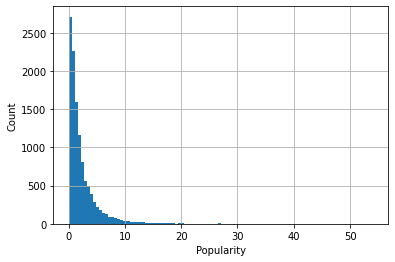

In [22]:
# histogram showing distribution of popularity
post_popularity_scaled['popularity'].hist(bins = 100)
plt.xlabel('Popularity')
plt.ylabel("Count")
plt.show()

Based on this popularity metric, we can establish the top trending fashion posts across Instagram in April 2020.

A lot of these posts were picked up by Instagram's algorithm for days in hashtag top section, while some that did not appear in the section but had a good LTF and growth rate also show up here.



In [23]:
# create new dataframe with the top 20 popular posts based on calculated popularity
top_20_popularity = post_popularity_scaled.sort_values('popularity', ascending=False)[:20]
top_20_popularity

,post_url,img_urls,max_likes,max_comments,max_views,followers,following,days_in_hashtag_top_section,growth_rate,LTF,popularity
5658,https://www.instagram.com/p/B-cuVYrJncn/,{https://finesse-instagram-post-images.s3-us-w...,2283,151,NaN,4487,896,1.000000,0.004542,0.280772,54.084006
11341,https://www.instagram.com/p/B-2LsSkpeoZ/,{https://finesse-instagram-post-images.s3-us-w...,43679,371,NaN,22800,767,0.000000,0.003373,1.000000,50.033731
3406,https://www.instagram.com/p/B_NkieupTpm/,{https://finesse-instagram-post-images.s3-us-w...,3083,73,NaN,1649,1342,0.000000,0.004853,0.990616,49.579319
5256,https://www.instagram.com/p/B_HxniXh4lX/,{https://finesse-instagram-post-images.s3-us-w...,968,49,NaN,1556,962,0.777778,0.003785,0.338299,48.063893
5866,https://www.instagram.com/p/B_OLFzNgQRJ/,{https://finesse-instagram-post-images.s3-us-w...,10910,146,NaN,7235,463,0.111111,0.101420,0.790949,45.006085
11259,https://www.instagram.com/p/B_CHJzXDeNF/,{https://finesse-instagram-post-images.s3-us-w...,1109,50,NaN,4038,1109,0.916667,0.007006,0.148561,44.164798
9320,https://www.instagram.com/p/B-9fgRUqRo5/,{https://finesse-instagram-post-images.s3-us-w...,20478,31,NaN,48600,5,0.777778,0.004560,0.218422,42.077828
5885,https://www.instagram.com/p/B_ZMPh6l1qm/,{https://finesse-instagram-post-images.s3-us-w...,1161,104,NaN,980,901,0.111111,0.413569,0.668118,41.986055
9317,https://www.instagram.com/p/B-4GhjnK7Uk/,{https://finesse-instagram-post-images.s3-us-w...,25242,31,NaN,48600,5,0.583333,0.006046,0.269159,36.851756
1522,https://www.instagram.com/p/B_FovwcH1Vq/,{https://finesse-instagram-post-images.s3-us-w...,3151,40,NaN,7693,69,0.638889,0.024816,0.214694,36.538420


Here are the Top 3 trending fashion posts based on the calculated popularity metric:

In [24]:
Image(url=top_20_popularity.iloc[0]['img_urls'][1:-1], width = 300, height = 300)



In [25]:
Image(url = top_20_popularity.iloc[1]['img_urls'][1:-1].split(',')[0], width = 300, height = 300)


In [26]:
Image(url=top_20_popularity.iloc[2]['img_urls'][1:-1], width = 300, height = 300)

Now that a metric for calculating the popularity of posts has been established, the next aim is to use this metric as a label for training a DNN on the comments. Such a model could have potential use in predicting popular fashion trends through NLP.

To train the model on comments, a threshold on the popularity value must be established to classify very popular posts.


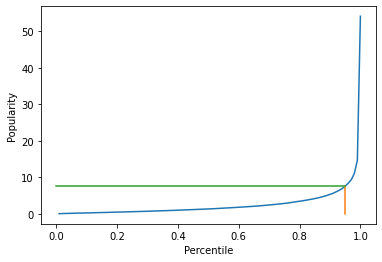

The 95th percentile is: 7.6049


In [28]:
# graph showing percentile of popularity to determine threshold
post_popularity_scaled['popularity'].quantile(np.linspace(0.01, 1, num=100)).plot()
plt.plot((0.95,0.95),(0,post_popularity_scaled['popularity'].quantile(0.95)))
plt.plot((0,0.95),(post_popularity_scaled['popularity'].quantile(0.95),post_popularity_scaled['popularity'].quantile(0.95)))
plt.xlabel("Percentile")
plt.ylabel("Popularity")
plt.show()
print("The 95th percentile is: " + str(round(post_popularity_scaled['popularity'].quantile(0.95), 4)))

From the graph, an insane rise is seen in the popularity after ~7.5. This corresponds to the 95th percentile. 

This statistic reveals how unbalanced our dataset actually is. Out of more than ~11000 posts, only about 5% (550) are extremely popular with a metric above 7.5.








## Data Pre-Processing 

This stage will involve data pre-processing and cleaning to get our dataset ready for training a DNN.

**Popularity Label**

The Popularity metric calculated in the last part will be used as the label for the DNN.

At the end, we discovered that only ~5% of the posts are extremely popular. 

These extremely popular posts had a popularity value greater than 7.6049. A binary classification will now be done where a post with a popularity greater than the threshold value of ~7.6049 will be classified as popular. 



In [29]:
# set a threshold to classify very popular posts
threshold = post_popularity_scaled['popularity'].quantile(0.95)

# create a binary column for popularity
post_popularity_scaled['is_popular'] = np.where(post_popularity_scaled['popularity']>=threshold, 1, 0)

# create new dataframe with post and binary popularity
is_post_popular = post_popularity_scaled[['post_url','is_popular']]
is_post_popular.head()

,post_url,is_popular
0,https://www.instagram.com/p/B-y2oOeDpj2/,0
1,https://www.instagram.com/p/B_B4e5qDtOU/,0
2,https://www.instagram.com/p/B-3-Skoj2ub/,0
3,https://www.instagram.com/p/B_UhfCuDnJU/,0
4,https://www.instagram.com/p/B-6isIeD-0-/,0


In [30]:
# counting number of popular posts
sum(is_post_popular['is_popular'])

582

It is seen that only 582 out of the 11000 posts on Instagram were extremely popular.

Training a model with such a huge class imbalance would lead to poor performance.

**This class imbalance will be corrected later by oversampling the minority class and undersampling the majority class.**


**Comments**

The comments need to be cleaned in order to generate word embeddings to pass into the DNN.

The model will attempt to classify extremely popular posts based on the embeddings generated by comments. 

In [31]:
#create dataframe with only posts and comments
only_comments = post_metrics_and_comments[['post_url','concatenated_comments']]
only_comments

,post_url,concatenated_comments
0,https://www.instagram.com/p/B-y2oOeDpj2/,@_o9.02 가입하자 연재야😘|아고 ㅠㅠㅠㅠ 힘드실텐데 아자아자 화이팅입니다 !!...
1,https://www.instagram.com/p/B_B4e5qDtOU/,@nam_bbs 정말요?🙌|옷입는 스타일 너무너무 멋있으세요 ☺️|코디 너무 좋아요...
2,https://www.instagram.com/p/B-3-Skoj2ub/,❤️|헐 선생님....멋져요....♥️|워료일 쪼아~ 최고로 쪼아~|Very sum...
3,https://www.instagram.com/p/B_UhfCuDnJU/,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ배불러졌다는게 너무 웃겨욬ㅋㅋㅋㅋㅋ|깔끔한 쓰앵님🤭👍🏿|😍😍😍😍❤...
4,https://www.instagram.com/p/B-6isIeD-0-/,극복 나이스👍🏻|@mndp404 시간은 결국 흐르니 ㅠㅠ|내일도 화요팅~!|@yeo...
...,...,...
11632,https://www.instagram.com/p/B_AlZo0AWJX/,🔥|❤️⚡️❤️⚡️|❤️⚡️❤️⚡️|❤️⚡️❤️⚡️|❤️⚡️❤️⚡️|❤️⚡️❤️⚡️...
11633,https://www.instagram.com/p/B_F0LX6laRg/,❤️|💙💙💚|YES!!! One of my last shoots before the...
11634,https://www.instagram.com/p/B-xmPs4F_br/,💐💐💐💐👏🏼🔝🔝🔝🎉|Verified ✨✨|Wow😍|😍😍😍😍|beautiful bab...
11635,https://www.instagram.com/p/B-7FRqKpzy3/,Happy birthday 😍 reply to dena Bali ho nhi 🙌|👶...


Cleaning of Comments involves the following stages:
- Convert emojis to text - emojis are an important indicator of popularity on social media.
- Convert text to lowercase
- Remove all punctuation
- Remove hashtags and mentions

In [32]:
# Cell takes ~3 minutes to run

# Function to convert emoji to text
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, " ".join(UNICODE_EMO[emot].replace(",","").replace(":"," ").split(" ")))
        text = text.replace("  ", " ").strip()
    return text

# Function to clean text to lower and remove punctuation
def clean_text(text):
  text =' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", text).split())
  text = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", text).split())
  text = text.lower()
  return text

# Add cleaned comments to list
list_of_comments = []  
for c in only_comments["concatenated_comments"]:  
  cleaned_comments = clean_text(convert_emojis(c))
  list_of_comments.append(cleaned_comments)


In [33]:
# create final dataframe with posts, labels and cleaned comments
final_df = only_comments.merge(is_post_popular, on='post_url')
final_df["cleaned_comments"] = list_of_comments
final_df = final_df.drop(['concatenated_comments'], axis=1)
final_df.head()

,post_url,is_popular,cleaned_comments
0,https://www.instagram.com/p/B-y2oOeDpj2/,0,@_o9 02 가입하자 연재야 face_blowing_a_kiss |아고 ㅠㅠㅠㅠ ...
1,https://www.instagram.com/p/B_B4e5qDtOU/,0,_bbs 정말요 raising_hands |옷입는 스타일 너무너무 멋있으세요 smi...
2,https://www.instagram.com/p/B-3-Skoj2ub/,0,red_heart ️|헐 선생님 멋져요 heart_suit ️|워료일 쪼아~ 최고로...
3,https://www.instagram.com/p/B_UhfCuDnJU/,0,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ배불러졌다는게 너무 웃겨욬ㅋㅋㅋㅋㅋ|깔끔한 쓰앵님🤭 thumbs_...
4,https://www.instagram.com/p/B-6isIeD-0-/,0,극복 나이스 thumbs_up light_skin_tone | 시간은 결국 흐르니 ...


**Generate word embeddings from cleaned comments**

After cleaning the comments, word embeddings need to be generated in order to pass them into the DNN.

Following steps are involved in this process:
- Set various parameters for generating embeddings:
  - Vocab_size : Number of unique words to consider in embeddings
  - Emdedding_dim: Dimension of embeddings to generate
  - Max_length: Maximum length of each comment to limit size in embeddings
  - Trunc_Type: Type of padding to embeddings - 'post' implies padding at the end 
  - Oov_tok: Token to represent out of vocabulary words
- First tokenize the comments into individual words
- Generate sequences from the tokens as embeddings
- Pad the emdeddings to ensure they have the same length

In [34]:
# set the comments as X (features) and popularity as y (label)
X = final_df['cleaned_comments']
y = final_df['is_popular']

# set parameters for embeddings
vocab_size = 50000
embedding_dim = 32
max_length = 500
trunc_type='post'
oov_tok = "<OOV>"

# tokenize comments
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

# create word index matching words to numeric representation
word_index = tokenizer.word_index

# generate sequences as embeddings
sequences = tokenizer.texts_to_sequences(X)

# pad the sequences
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)




**Fix Class Imbalance**

As mentioned earlier, there is a huge imbalance of the two classes in our dataset. Only ~5% of the ~11000 posts are classified are popular. With a 5:95 split, any model trained on this dataset would perform poorly as it lacks sufficient information to properly predict the popular posts.

In order to correct this imbalance, the minority class (popular) will be over-sampled by a scale of 0.5 and the majority class (not popular) will be under-sampled by a scale of 0.5

In the case of over-sampling, simply duplicating examples in the minority class is not helpful, as these examples don’t add any new information to the model.

Instead, new examples can be synthesized from the existing examples. This is known as Synthetic Minority Oversampling Technique, or SMOTE for short - based on this research paper:

https://arxiv.org/abs/1106.1813

SMOTE works by selecting examples that are close in the feature space. A random example from the minority class is first chosen and its k-nearest neighbors are found. A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

The approach is effective because new synthetic examples from the minority class are created that are plausible, that is, are relatively close in feature space to existing examples from the minority class.

A mixture of SMOTE and under-sampling works better than just under-sampling so both of the techniques are used.

In [35]:
# set X as embeddings
X = padded

# counter to depict initial class imbalance
counter = Counter(y)
print(counter)

# over-sampling and under-sampling
over = SMOTE(sampling_strategy=0.5, random_state = 42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 42)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X1, y1 = pipeline.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y1)
print(counter)


Counter({0: 11055, 1: 582})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 11054, 1: 5527})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


It can be seen that the intial 5:95 split is now a 1:2 split.

The class imbalance is corrected and now the model can be trained.

**Train-Validation Split**


The final step before building the model architecture is dividing the data into training and validation.

A 80-20 split is used, along with stratified sampling to ensure an equal distribution of the classes in the training and validation data.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1,test_size=0.2, random_state=0, stratify = y1)

## Model Architecture

**Choosing the Baseline Model**

The baseline model used is a Long Short-Term Memory neural network (LSTM). The generated word embeddings are used as input to the LSTM model to
learn the long distance contextual dependency among words.

An LSTM is used as the baseline model for the following reasons:

- Comments are generally short texts. To detect the popularity polarity from short texts, we need to explore deeper semantics of words using deep learning methods. An LSTM is used for learning long-distance dependency between word
sequences in short texts.

- Because an LSTM considers the context of words and explores the deeper semantics, it is preferred over other methods of text classification like Naive Bayes and TF-IDF - all of which do not consider long distance dependencies.

-  For social media content which is very short and diverse, it is difficult to obtain useful features for classification. Conventional supervised learning methods such as bag-of-words model using TF-IDF, and probabilistic
model using Naïve Bayes, usually need hand-crafted features. An LSTM model does not need hand-crafted features and is much more effective for short text classification. 

- LSTM models have shown great performance in prior research to classify social media comments - https://www.aclweb.org/anthology/O18-1021.pdf. So, an LSTM would work well in a similar setting of short text classification.


**Building the Model Architecture and Adding Layers** 

In [37]:
# building the model architecture
tf.random.set_seed(42)
model = tf.keras.Sequential([
                             
    # an embeddings layer with dimensions for vocab_size, word embeddings and max length of comments
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

    # a bi-directional LSTM layer to consider forward and backward context
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    
    # a dropout layer which randomly drops 20% of the neurons to reduce overfitting
    tf.keras.layers.Dropout(0.2),

    # hidden dense layer of DNN with relu activation to converge fast and prevent vanishing gradients
    tf.keras.layers.Dense(6, activation='relu'),

    # final output layer with sigmoid activation for binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# binary cross-entropy loss for binary classifcation
# adam's optimizer to optimize weights chosen through cross-validation
# accuracy and recall as metrics for evaluating model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy','Recall', 'Precision'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           1600000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 1,650,445
Trainable params: 1,650,445
Non-trainable params: 0
_________________________________________________________________


In [38]:
# fit model on training data and evaluate model on validation data
num_epochs = 10
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
415/415 [==============================] - 23s 56ms/step - loss: 0.5513 - accuracy: 0.7316 - recall: 0.4051 - precision: 0.6582 - val_loss: 0.4777 - val_accuracy: 0.8037 - val_recall: 0.7830 - val_precision: 0.6782
Epoch 2/10
415/415 [==============================] - 22s 53ms/step - loss: 0.4273 - accuracy: 0.7967 - recall: 0.5953 - precision: 0.7437 - val_loss: 0.2561 - val_accuracy: 0.9195 - val_recall: 0.8146 - val_precision: 0.9356
Epoch 3/10
415/415 [==============================] - 22s 53ms/step - loss: 0.1931 - accuracy: 0.9435 - recall: 0.8788 - precision: 0.9478 - val_loss: 0.2243 - val_accuracy: 0.9313 - val_recall: 0.8282 - val_precision: 0.9602
Epoch 4/10
415/415 [==============================] - 22s 53ms/step - loss: 0.1801 - accuracy: 0.9450 - recall: 0.8867 - precision: 0.9450 - val_loss: 0.2389 - val_accuracy: 0.9285 - val_recall: 0.8834 - val_precision: 0.9005
Epoch 5/10
415/

**Model Evaluation**

Based on the metrics above and the graphs below, over the course of 10 epochs, the model was able to attain a **training accuracy of ~97%** and a **validation accuracy of ~94%**.

The high validation accuracy illustrates how effective the LSTM model is in predicting popularity of posts based on their comments.

However, in this particular scenario, **Precision** and **Recall** are better metrics to evaluate our model. This is because we are more concerned with correctly identifying the popular posts.

Although the precision is a bit fickle due to the low number of epochs, our **final precision is ~94%.** This means that out of all the posts that our model predicted as popular, **94%** were actually popular on Instagram.

The most important metric for our scenario is **Recall**. This is because recall discourages false negatives, which is very important to us. A false negative means that the post was actually trending on Instagram and our model missed out in identifying this popular post. Our final **Recall is ~88%**, which is a decent metric given the high volume of comments. This means that of all the trending posts on Instagram, our model was able to correctly identify **88%** of them as popular based on their comments.





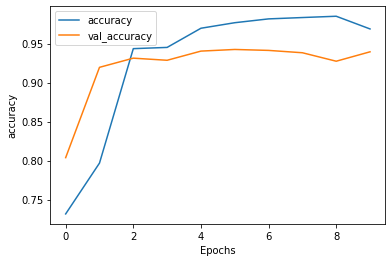

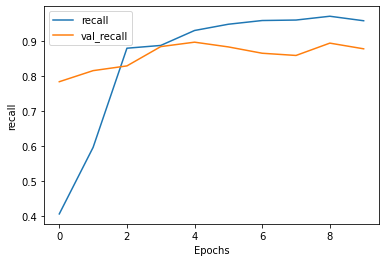

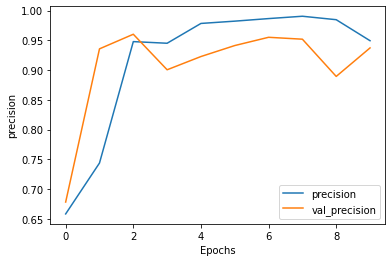

In [39]:
# code to plot graphs for model evaluation
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# plot accuracy over epochs
plot_graphs(history, 'accuracy')

# plot recall over epochs
plot_graphs(history, 'recall')

# plot precision over epochs
plot_graphs(history, 'precision')

## Alternate Features and Models

#### **Improve Current Model** 

While the existing model did perform really well at predicting popular posts from comments, certain features/implementations could be done that might enhance the model.





**Google Translate**: 

There were a few comments that were in a language other than English. With the current model, the words from these comments had their own embeddings generated, regardless of whether the word had the same meaning in English. If these foreign language words were translated into English, then similar words would have the same embeddings as their synonyms in English. This would generate embeddings better representative of the meanings of words, and thus improve model performance. This would be done with the help of the **Googletrans** library that uses the Google Translate API to translate Python strings in other languages into English. More information here: https://towardsdatascience.com/translate-a-pandas-data-frame-using-googletrans-library-fb0aa7fca592


**Pre-trained word embeddings**: 

Another way to improve upon the current model would be to use pre-trained word embeddings, a form of transfer learning. Pretrained Word Embeddings are the embeddings learned in one task that are used for solving another similar task. These embeddings are trained on large datasets, saved, and then used for solving other tasks.

Currently the model architecture generates its own embeddings from the corpus using the Tokenizer API in Keras. 

The **fit_on_text** method updates internal vocabulary based on a list of comments. This method creates the vocabulary index based on word frequency. 

The **words_to_sequences** method transforms each comment to a sequence of integers. It takes each word in the comment and replaces it with its corresponding integer value from the word_index dictionary. 

An **embedding layer** is added in the model architecture which is intialized with random weights and takes our vocab_size, embeddings_dim and max_length as input. This layer will learn an embedding for all of the words in the training dataset.

With **Transfer Learning**, the following pre-trained word embeddings can be used:

- **Word2Vec**: Word2Vec is one of the most popular pretrained word embeddings developed by Google. It is trained on the Google News dataset of about 100 billion words. Word2Vec relies on two approcahes to generate embeddings - Bag of Words and Skip-gram. **Continuous Bag-of-Words (CBOW)** model learns the focus word given the neighboring words whereas the **Skip-gram** model learns the neighboring words given the focus word. More info: https://code.google.com/archive/p/word2vec/

- **GloVe**: This was developed by Stanford. GloVe learns to encode the information of the probability ratio in the form of word vectors. It uses a co-occurrence matrix that tells us how often a particular pair of words occur together, computes the probabilities of words appearing together and derives relationships between words. More info: https://nlp.stanford.edu/projects/glove/

Either one of these pre-trained word embeddings could be used in our model, with very little code to add:
- First, simply download the pre-trained embeddings as a dictionary. 
- Create an embeddings matrix  with one embedding for each word in the training dataset. Look into the word_index generated by the Keras tokenzier to find unique words in the training data, and add their corresponding emdedding vector from the pre-trained emdedding dictionary. 
- When adding the Keras embeddings layer to the model architecture, set the weights equal to the embeddings matrix generated above, dimension equal to the dimesion of pre-trained embeddings and the trainable parameter to false as we do not want to update the learned word weights in this model.

Using pre-trained embeddings has the following advantages:
- Pretrained word embeddings capture the semantic and syntactic meaning of a word as they are trained on large datasets. They can boost performance of NLP models.
- Generating word embeddings from scratch increases training time due to large number of trainable parameters. Pre-trained embeddings are much faster, as we do not update the learned word weights.
- There is a sparsity of training data if our corpus has a large volume of rare words. The embeddings learned from scratch cannot arrive at the right representation of the word. Pre-trained embeddings do not face this problem as they have a rich vocabulary.

#### **Build New Model**

While leveraging NLP techniques on comments to predict popular posts has certainly proved an effective model, an alternate approach to this problem could be to use Computer Vision technologies.

More specifically, we can build a **Convolutional Neural Network** that uses the images themselves to predict whether the post would trend on Instagram. The CNN could analyze certain features from images that contribute to post popularity - Bright Colors, Image Orientation with focus on clothing rather than person etc.


**Theory**:

CNNs are different from DNNs in the way that apart from the dense layers that make up a neural network, the model architecture has additional layers called **convolutional** and **pooling** layers.

With a CNN, the input is a tensor in the shape of number of images x their dimension (height, width, depth).

The **convolutional layer** performs a mathematical operation called convolution to the image pixels to extract the high-level features (color, edges, gradient orientation) of the image.

The **pooling layer** reduces the dimension to decrease the computational power required to process the data.

More info about CNNs here: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53



**Why to use CNN?**

Because of way CNNs are designed and their implementation described above, a Convolutional Neural Network would be the perfect model in our case to predicting trending posts on Instagram by using the images we have in our data. 

A ConvNet is able to successfully capture the Spatial and Temporal dependencies in an image through the application of relevant filters. Therefore the model can understand the sophistication and certain features behind popular images.

**Data Pre-Processing**:

We already calculated the popularity metric and the is_popular binary variable. This will be used as the label for the CNN.

For the features, we will use the images themselves. We can extract these images using the **image_url** column in the dataset and download them into a directory on Colab using the **wget.download()** method. Separate directories for training and validation can be made and images in random order can be downloaded into these directories.


**Model Architecture**:

The model architecture will be a bit different than a DNN because of the convolutional and pooling layers.

**tf.keras.layers.Conv2D()** will be used to build the convolutional layer taking in the input shape of the images.

**tf.keras.layers.MaxPooling2D()** will be used to build the pooling layer with input of the dimension we want to reduce the image by.

Multiple convolutional and pooling layers can be added to the model architecture after which **tf.keras.layers.Flatten()** is used to flatten the results to feed into a DNN.

After building these layers, the rest of architecture is similar to a DNN wih dense and output layers.


**Model Training and Overfitting**:

To counter the problem of overfitting while training and increase the amount of training data, a technique called **Image Augmentation** can be applied.

This technique uses the **ImageDataGenerator()** method to rotate, shift, zoom and flip images. This way we have more images to train on, thereby reducing overfitting.

The **flow_from_directory()** method takes in the directory of images created in the last part and outputs a generator which we can then fit on our training data by using the **model.fit_generator()** method.

With these steps, we have trained a Convolutional Neural Network that predicts trending posts on Instagram through images. Evaluation metrics similar to the ones we utilized earlier can then be applied to judge the effectiveness of our model.

## Summary

Through this notebook I accomplished the following tasks:

- Devised a popularity metric by leveraging various features provided in different datasets to calculate popularity of posts on Instagram.
- Used the popularity metric to establish top trending posts on Instagram in April 2020.
- Used NLP techniques to develop an LSTM model with high values (above 90%) of accuracy, precision and recall that predicts popularity of posts based on their comments.
- Suggested techniques to improve/enhance the LSTM model.
- Discussed an alternate model to predict trending posts by using a Convolutional Neural Network.